# Classical decomposition to compute trend and seasonality

In this notebook we show how to compute a classical decomposition of a time series into trend and seasonality using Pandas and Statsmodels



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set_context("talk")

# Load data

In [2]:
df = pd.read_csv(
    "../Datasets/example_retail_sales.csv", parse_dates=["ds"], index_col=["ds"]
)

In [3]:
df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


<AxesSubplot:xlabel='ds'>

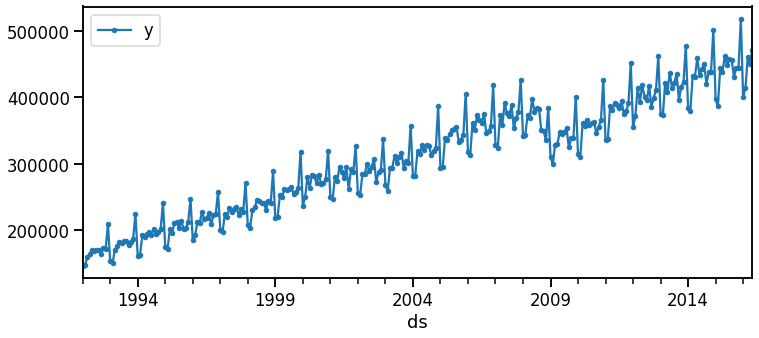

In [4]:
fig, ax = plt.subplots(figsize=[12, 5])

df.plot(ax=ax, marker=".")

# Classical decomposition

## 1. Compute trend

The data has a monthly frequency and we observe yearly seasonality (i.e., a pattern which repeats every 12 periods).

Therefore, a 2x12-MA is recommended for the trend.

In [5]:
window_size = 12
df["trend"] = (
    df.rolling(window=window_size)
    .mean()  # Apply the 12-MA without a centered window
    # The average is computed at the end of the window
    .rolling(window=2)
    .mean()  # Apply the 2-MA without a centred window
    # The average is computed at the end of the window
    .shift(-window_size // 2)  # Shift is required to align the 2x4-MA to what a
    # centered window would have produced
    # Integer division is used as shift() requires an int
)

## 2. De-trend the data

In [6]:
df["y_detrended"] = df["y"] - df["trend"]

## 3. Average over de-trended data for each month

In [7]:
# Average over each month
df["month"] = df.index.month
df.head()

,y,trend,y_detrended,month
ds,,,,
1992-01-01,146376,NaN,NaN,1
1992-02-01,147079,NaN,NaN,2
1992-03-01,159336,NaN,NaN,3
1992-04-01,163669,NaN,NaN,4
1992-05-01,170068,NaN,NaN,5


In [8]:
seasonality = df.groupby("month").mean()["y_detrended"]
seasonality.name = "seasonality"
seasonality

month
1    -31085.898551
2    -32941.297101
3      3032.637681
4     -2933.978261
5     13554.688406
6      4457.835145
7      4140.364583
8     10267.178819
9    -11945.057292
10    -3233.472222
11    -1135.296875
12    47751.626812
Name: seasonality, dtype: float64

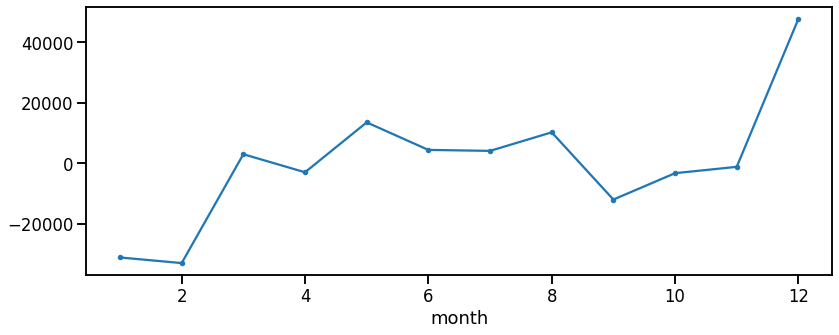

In [9]:
fig, ax = plt.subplots(figsize=[12, 5])
seasonality.plot(y="seasonality", ax=ax, marker=".")
plt.tight_layout()

## 4. Repeat seasonal pattern each year

In [10]:
df = df.merge(right=seasonality, left_on="month", right_index=True)
df = df.sort_index()
df.head()

,y,trend,y_detrended,month,seasonality
ds,,,,,
1992-01-01,146376,NaN,NaN,1,-31085.898551
1992-02-01,147079,NaN,NaN,2,-32941.297101
1992-03-01,159336,NaN,NaN,3,3032.637681
1992-04-01,163669,NaN,NaN,4,-2933.978261
1992-05-01,170068,NaN,NaN,5,13554.688406


## 5. Compute residual component 

In [11]:
df["residual"] = df["y"] - df["trend"] - df["seasonality"]

## 6. Plot results

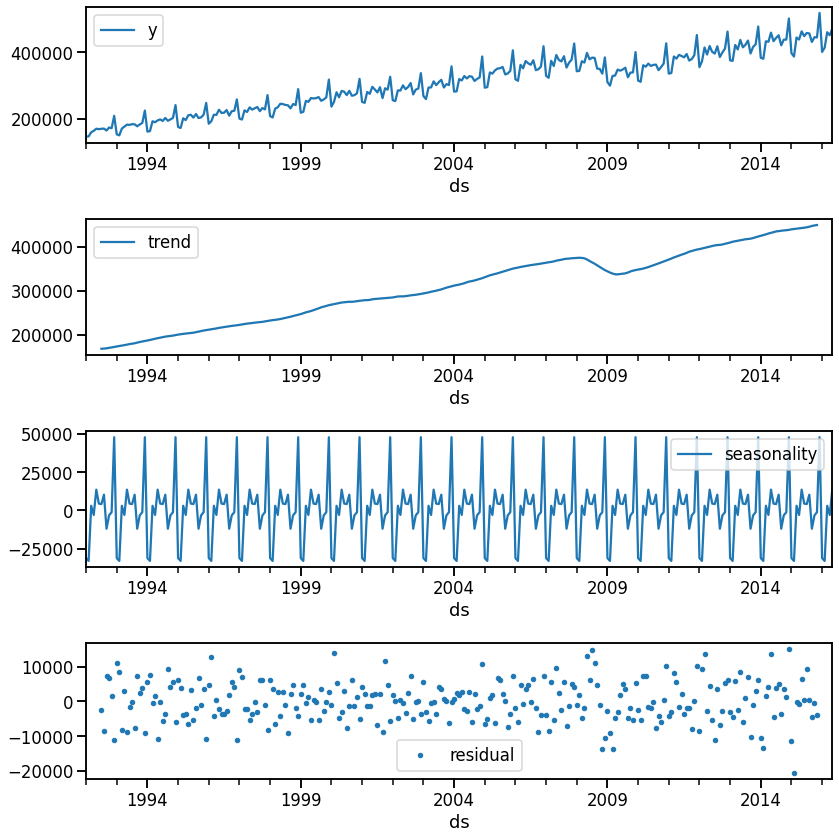

In [12]:
fig, ax = plt.subplots(nrows=4, figsize=[12, 12])

df["y"].plot(ax=ax[0], legend="y")
df["trend"].plot(ax=ax[1], legend="trend")
df["seasonality"].plot(ax=ax[2], legend="seasonality")
df["residual"].plot(ax=ax[3], marker=".", legend="residual", ls="None")

plt.tight_layout()

# Classical decomposition using statsmodels

Statsmodels provides a method called `seasonal_decompose` which implements a classical (aka naive) decomposition.

In [13]:
res = seasonal_decompose(x=df["y"], model="additive", period=12)

In [14]:
res.trend.head(10)

ds
1992-01-01              NaN
1992-02-01              NaN
1992-03-01              NaN
1992-04-01              NaN
1992-05-01              NaN
1992-06-01              NaN
1992-07-01    168127.041667
1992-08-01    168537.583333
1992-09-01    169125.541667
1992-10-01    170120.958333
Name: trend, dtype: float64

The trend has missing values at the edges because a centered moving average is used to compute the trend.

In [15]:
res.seasonal.head(10)

ds
1992-01-01   -31080.009479
1992-02-01   -32935.408030
1992-03-01     3038.526752
1992-04-01    -2928.089190
1992-05-01    13560.577477
1992-06-01     4463.724216
1992-07-01     4146.253655
1992-08-01    10273.067891
1992-09-01   -11939.168220
1992-10-01    -3227.583151
Name: seasonal, dtype: float64

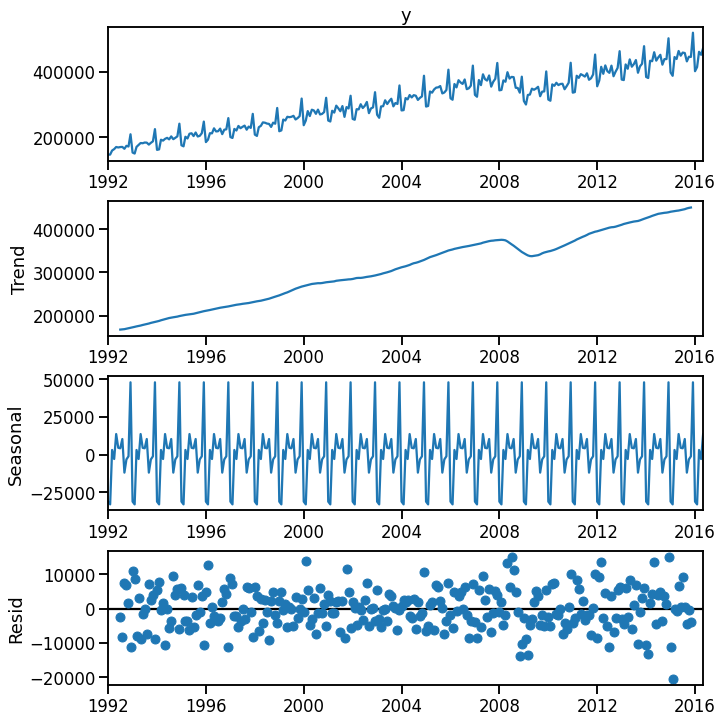

In [16]:
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=5)
res.plot();